# ML Project

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
import random



Importing dataset:

In [2]:
#path:
#file_path = r"C:\Users\vikto\Documents\Skole\Datadrevne_systemer\ML_Project\glass_data-4_lev.csv"
file_path = "Dataset/glass_data-4_lev.csv"
#importing file and print how the structure of data were inported. 
df = pd.read_csv(file_path)

# Define a mapping dictionary
type_mapping = {'T1': 0, 'T2': 1, 'T3': 2, 'T4': 3, 'T5': 4, 'T6': 5}

# Apply the mapping to the 'Type' column
df['Type'] = df['Type'].map(type_mapping)

#drop ID number
df = df.drop(columns=['Id'])

# Verify the 'Type' column is now of type int64
print(df['Type'].dtype)
df.info()

int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   RI      214 non-null    int64
 1   Na      214 non-null    int64
 2   Mg      214 non-null    int64
 3   Al      214 non-null    int64
 4   Si      214 non-null    int64
 5   K       214 non-null    int64
 6   Ca      214 non-null    int64
 7   Ba      214 non-null    int64
 8   Fe      214 non-null    int64
 9   Type    214 non-null    int64
dtypes: int64(10)
memory usage: 16.8 KB


### Small exploration of data:

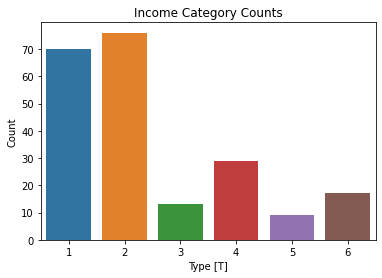

In [3]:
# Count the occurrences of each income category
type_counts = df['Type'].value_counts()
#order = ['T1','T2','T3', 'T4','T5','T6']
# Create a bar plot
sns.barplot(x=type_counts.index +1, y=type_counts.values) #order=order)
# Add labels and title
plt.xlabel('Type [T]')
plt.ylabel('Count')
plt.title('Income Category Counts')

# Show the plot
plt.show()

The data set clearly shows that T1, T2 is most frequently. 

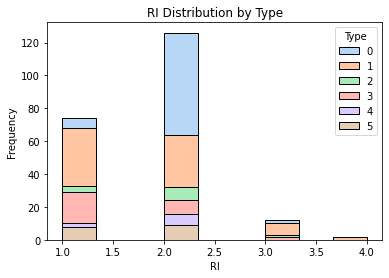

In [4]:
# Create a histogram of age with hue for income
sns.histplot(data=df, x='RI', hue='Type', multiple='stack', palette='pastel')

# Add labels and title
plt.xlabel('RI')
plt.ylabel('Frequency')
plt.title('RI Distribution by Type')

# Show the plot
plt.show()

In [5]:
#for col in df.columns[:-1]:  # Exclude the 'Type' column
 #   sns.boxplot(x='Type', y=col, data=df)
  #  plt.show()

### Make a neural network:

Split data to training and validation and Scale the data: 

In [6]:
# Prepare the Data for training:
X = df.drop(columns=['Type']).values  # Features (excluding 'Type' column)
y = df['Type'].values  # Labels

# Split Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
print(type(X_train[0][0]))

<class 'numpy.float64'>


Create pytorch model:

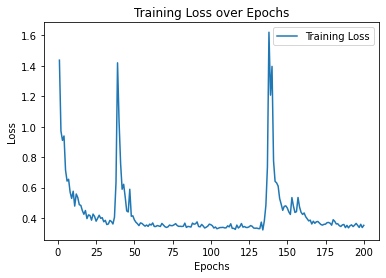

In [7]:

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=7, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=7)

# Build the Neural Network
class GlassClassifier(nn.Module):
    def __init__(self):
        super(GlassClassifier, self).__init__()
        self.fc1 = nn.Linear(9, 64)
        self.fc2 = nn.Linear(64, 90)
        self.fc3 = nn.Linear(90, 64)
        self.fc4 = nn.Linear(64, 6)  # 6 output units for 6 types
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = GlassClassifier()

# Step 5: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 6: Train the Model
# Define a list to store training losses
train_losses = []

# Define the number of epochs
num_epochs = 200

# Train the model and track the training loss
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Calculate average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

# Plot the training loss
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

Evaluate model:

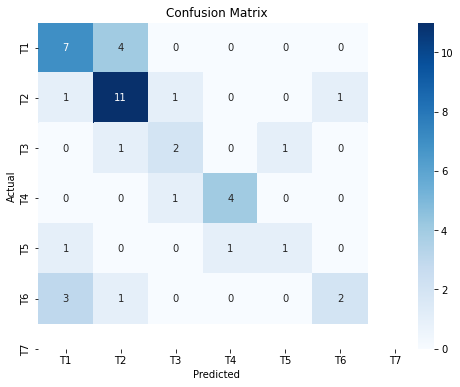

Validation Accuracy: 62.79%


In [8]:
# Step 7: Evaluate the Model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'T{i}' for i in range(1, 8)],
            yticklabels=[f'T{i}' for i in range(1, 8)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

correct = sum(pred == label for pred, label in zip(all_preds, all_labels))
accuracy = correct / len(all_labels)
#print()
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

In [9]:
import metoder
rf = metoder.randomforest(df)

In [10]:
gb = metoder.gradientboost(df)

In [11]:
lr = metoder.linearregression(df)

In [12]:
dr = metoder.decisionregressor(df)

In [13]:
mlp = metoder.mlpregression(df)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [14]:
svr = metoder.supportvectoregressor(df)

In [15]:
KNN = metoder.kneighborsregressor(df)

In [16]:
models = ['KNN Regressor', 'Linear Regression', 'Decision Tree Regressor' ,'Random Forest Regressor',
 'Gradient Boosting Regressor','Support Vector Regressor', 'MLP Regressor']
tests_score = [KNN, lr, dr, rf, gb, svr, mlp]
compare_models = pd.DataFrame({ "Algorithms": models, "Tests Score": tests_score })
compare_models.sort_values(by = "Tests Score", ascending = False)

,Algorithms,Tests Score
3,Random Forest Regressor,0.790698
4,Gradient Boosting Regressor,0.627907
2,Decision Tree Regressor,0.460032
0,KNN Regressor,0.407940
6,MLP Regressor,0.384087
5,Support Vector Regressor,0.354247
1,Linear Regression,0.287977


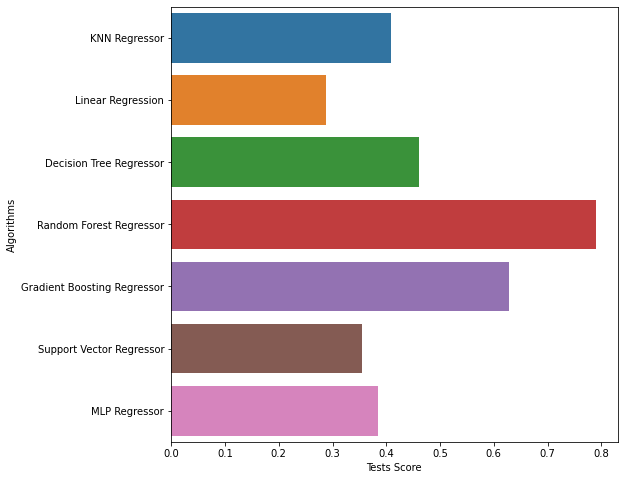

In [17]:
%matplotlib inline
plt.figure(figsize=(8,8))
sns.barplot(x = "Tests Score", y = "Algorithms", data = compare_models)
plt.show()